# 予測結果から、最適な装填枚数を決定する

## ライブラリの読み込み

In [ ]:
# ライブラリの読み込み

import pandas as pd

## 準備

In [ ]:
# パラメータ
CURRENCY_NUM = 2    # 金種数        
CASETTE_CAP = 4500  # 金種カセット容量(とりあえず金種で同じとする。)

# カセット装填枚数パターン設定(ex. [[1000, 1000]] 金種毎の配列)
START_NUM = 500     # この枚数から
END_NUM = 4500      # この枚数まで
STEP_NUM = 100      # この枚数刻みで、CASETTE_CAPを超えないカセットパターンを作成する

RE_ADJUST = True   # 再調整


## 初期化

In [ ]:
# 初期設定

# 容量オーバーチェック
if END_NUM > CASETTE_CAP:
    END_NUM = CASETTE_CAP

if START_NUM < 0:
    START_NUM = 0

cst_patern = [[i for i in range(START_NUM, END_NUM+STEP_NUM+1, STEP_NUM)] for j in range(CURRENCY_NUM)]
#print(cst_patern)
# [[500, 600, 700, 800, 900, 1000, 1100,...]]

# 現在のあり高(ex. [100,0 1000] 金種毎の配列)
cur_cash_pos = [0 for i in range(CURRENCY_NUM)]
#print(cur_cash_pos)
# [0, 0]

# インシデント
NO_INCIDENT = 0
EMPTY_INCIDENT = 1
FULL_INCIDENT = 2

## 現金予測データより、インシデント発生までの経過日数を計算する

In [ ]:
# ------------------------------------------------------------------------------
# 現金予測データより、インシデント発生までの経過日数を計算する
# ------------------------------------------------------------------------------
# 引数
# init_cash_pos : 初期のあり高
# predict[] : 現金予測データ

# 戻り値
# incident : 発生インシデント(0: なし、1: 切れ、2:あふれ)
# max_incident_days : インシデント(切れ、あふれ)発生までの経過日数

# 処理概要
# あり高に、初期あり高をセットする
# 現金予測データを読みだして、あり高を更新する
# 現在あり高より、インシデント(切れ、あふれ)を発生するか判断し、発生する場合は、その経過日付を結果に追加する
# 全部のパターンが終わったら、経過日付から最大の経過日付を取り出し、結果として返す
# データ内でインシデントが発生しない場合は、999(最大値)を返す
# ------------------------------------------------------------------------------
def get_incident_days(init_cash_pos, predicts, empty_num, full_num):
    # init_cash_pos : 初期のあり高
    # predict[] : 現金予測データ

    incident_days = []  # 経過日数

    cash_pos = init_cash_pos   # あり高に、初期あり高をセットする
    incident = NO_INCIDENT
    incident_days = len(predicts)-1 # 経過日数を最大にしておく

    for days, predict in enumerate(predicts):  # 現金予測データを読みだして、
        cash_pos += predict     # あり高を更新する
        #print(predict, cash_pos)
        if cash_pos <= empty_num:           # 切れの発生
            incident = EMPTY_INCIDENT
            incident_days = days
            break  
        elif cash_pos >=  full_num:          # あふれの発生
            incident = FULL_INCIDENT
            incident_days = days
            break
    
    return(incident, incident_days)



## 最長の経過日数をシミュレーションで求める

In [ ]:
# ------------------------------------------------------------------------------
# 金種により、最長の経過日数をシミュレーションで求める
# ------------------------------------------------------------------------------
# 引数
# currency_type : 金種

# 戻り値
# best_rep_num : 最適補充枚数
# max_days : インシデント発生までの経過日数

# 切れ枚数、あふれ枚数をセットする
# 現金予測データをセットする
# カセット装填枚数パターン設定からパターンを読みだす
# 初期のあり高をカセット装填枚数パターン設定からセットする
# 現金予測データより、インシデント発生までの経過日数を計算する
# 結果をopt_resultにセットする
# すべてのパターンの処理が終わったら、最長の経過日数のパターンを最適なパターンとする
# ------------------------------------------------------------------------------
def get_optimal_pattern(currency_type, predicts, empty_num, full_num):

    result = []
    # カセット装填枚数パターン設定からパターンを読みだす
    for cstp, rep_num in enumerate(cst_patern[currency_type]):  
        # 現金予測データより、インシデント発生までの経過日数を計算する
        incident, incident_days = get_incident_days(rep_num, predicts, empty_num, full_num)
        # 結果をopt_resultにセットする 
        result.append([incident, incident_days, rep_num])

    print('結果[インシデント,経過日数]:',result)
    #  [[1, 0, 500], [1, 0, 600], [1, 0, 700], ......]

    # すべてのパターンの処理が終わったら、最長の経過日数のパターンを最適なパターンとする

    # 経過日数を取り出す
    days = [row[1] for row in result]
    print('経過日数だけを取り出す:',days)
    # [0, 0, 0, 0, 0, 0, 0, 1, 1, .....]

    # 最大の経過日数
    max_days = max(days)
    print('最大の経過日数:',max_days)

    # 最大日数が同じ場合は、最少の装填枚数を選ぶ
    # 経過日数の複数の最大値のインデックスを全て取得
    max_idx = [ i for i, data in enumerate(days) if data == max(days)]
    print('経過日数が最大のインデックス:',max_idx)
    # [37, 38, 39]

    # 該当する装填枚数を得る
    rep_nums = [result[i][2] for i in max_idx]
    print('経過日数が最大の場合の装填枚数を得る:',rep_nums)
    # [4200, 4300, 4400]

    # 最小の装填枚数のインデックスを選ぶ
    best_rep_num = min(rep_nums)
    print('最小の装填枚数:',best_rep_num)

    # 決定した装填枚数よりインシデントを選ぶ
    # 結果データより
    for rt in result:
        # 装填枚数が同じであれば
        if rt[2] == best_rep_num:
            # そのインシデントを選ぶ
            incident = rt[0]
            break

    # 経過日数は0開始なので、+1しておく
    return [best_rep_num, max_days + 1, incident]

## 金種毎に最長の経過日数と補充枚数を求める

In [ ]:
# ------------------------------------------------------------------------------
# 金種毎に最長の経過日数と補充枚数を求める
# ------------------------------------------------------------------------------
def get_rep_notes(predict_data, cash_empty_num, cash_full_num):

    result = []
    for currency_type in range(CURRENCY_NUM):
        predicts = predict_data[currency_type]          # 現金予測データ
        empty_num = cash_empty_num[currency_type]       # 切れ枚数
        full_num = cash_full_num[currency_type]         # あふれ枚数
        print("金種:",currency_type, '===============================================')
        result.append(get_optimal_pattern(currency_type, predicts, empty_num, full_num))
    print("結果:",result, '===============================================')

    # 経過日数のリスト
    days=[i[1] for i in result]
    print('経過日数のリスト:',days)
    # 短い経過日数
    days_min = min(days)
    print('短い経過日数:',days_min)

    # 短い経過日数の金種インデックス
    days_min_idx = days.index(min(days))
    print('短い経過日数の金種インデックス:',days_min_idx)

    # 再調整機能あり
    if RE_ADJUST:

        # 該当インデックス以外の金種の装填枚数を再計算する
        for currency_type in range(len(result)):
            # 最短の経過日数でないインデックスについて
            if currency_type != days_min_idx:
                # 補充枚数を再調整する
                predicts = predict_data[currency_type][0:days_min]          # 現金予測データ
                print('再調整の予測',predicts)

                empty_num = cash_empty_num[currency_type]       # 切れ枚数
                full_num = cash_full_num[currency_type]         # あふれ枚数
                print("調整金種:",currency_type)
                result[currency_type] = get_optimal_pattern(currency_type, predicts, empty_num, full_num)
                print('再調整の結果',result[currency_type])
    return result
            

## テスト

金種: 0 ===============================================
結果[インシデント,経過日数]: [[1, 0, 500], [1, 1, 600], [1, 1, 700], [1, 1, 800], [1, 1, 900], [1, 1, 1000], [1, 2, 1100], [1, 2, 1200], [1, 2, 1300], [1, 2, 1400], [1, 2, 1500], [1, 2, 1600], [1, 2, 1700], [1, 21, 1800], [1, 21, 1900], [1, 21, 2000], [1, 21, 2100], [1, 22, 2200], [2, 14, 2300], [2, 14, 2400], [2, 14, 2500], [2, 14, 2600], [2, 14, 2700], [2, 14, 2800], [2, 14, 2900], [2, 14, 3000], [2, 13, 3100], [2, 13, 3200], [2, 8, 3300], [2, 8, 3400], [2, 8, 3500], [2, 8, 3600], [2, 8, 3700], [2, 8, 3800], [2, 8, 3900], [2, 8, 4000], [2, 8, 4100], [2, 8, 4200], [2, 7, 4300], [2, 5, 4400], [2, 5, 4500], [2, 5, 4600]]
経過日数だけを取り出す: [0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 21, 21, 21, 21, 22, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 5, 5, 5]
最大の経過日数: 22
経過日数が最大のインデックス: [17]
経過日数が最大の場合の装填枚数を得る: [2200]
最小の装填枚数: 2200
金種: 1 ===============================================
結果[インシデント,経過日数]: [[1, 1, 500], [1, 1, 600], [1,

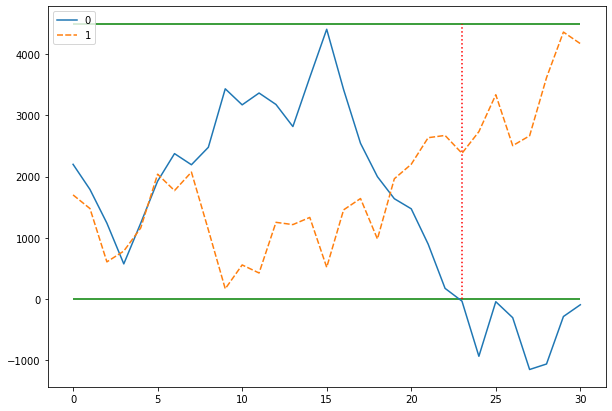

In [ ]:
# テスト
# 現金予測データ(入力データ)
import random

DAYS=30
predict_data = [[random.randint(-1000, 1000) for i in range(DAYS)],
                [random.randint(-1000, 1000) for i in range(DAYS)]]

# カセット容量(ex.[2500, 2500] 金種毎の配列)
cash_full_num = [CASETTE_CAP for i in range(CURRENCY_NUM)]

# 切れ枚数(ex. [100, 100] 金種毎の配列)
cash_empty_num =  [100 for i in range(CURRENCY_NUM)]

rep_notes_result = get_rep_notes(predict_data, cash_empty_num, cash_full_num)
print('最適な補充枚数', rep_notes_result)

# グラフで確認

cash_position = [[i[0]] for i in rep_notes_result]

for i, predict in enumerate(predict_data):
    for notes in predict:
        cash_position[i].append(notes + cash_position[i][-1])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.lineplot(data=cash_position)
plt.hlines(0, 0, DAYS, color='g')
plt.hlines(CASETTE_CAP, 0, DAYS, color='g')
plt.vlines(rep_notes_result[0][1], 0, CASETTE_CAP, color='r',linestyles='dotted')